### Generating Qiskit's data

In [1]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5 + 5,  # 5 for test, 5 for predict
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [2]:
# the `test_features` and `test_labels` are of size which is double that of the `test_size` argument
# Since there are `test_size` items for each `adhoc_dimension`
import numpy as np


def split(obj: np.ndarray, n: int = 20):
    quarter = n // 4
    half = n // 2
    first = np.concatenate((obj[:quarter], obj[half : half + quarter]))
    second = np.concatenate((obj[quarter:half], obj[half + quarter :]))
    return first, second


test_features, predict_features = split(test_features)
test_labels, predict_labels = split(test_labels)

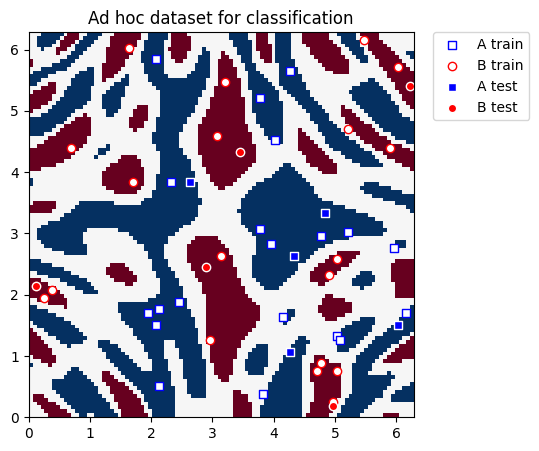

In [3]:
# Plot data
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

### Initializing Classiq's QSVM

In [4]:
## Classiq imports

from classiq import Pauli, construct_qsvm_model, execute, show, synthesize
from classiq.applications.qsvm import QSVMFeatureMapEntanglement

pauli_z_zz_feature_map_function_name = "pauli_feature_map"
pauli_z_zz_kwargs = {
    "paulis": [[Pauli.Z], [Pauli.Z, Pauli.Z]],
    "entanglement": QSVMFeatureMapEntanglement.CIRCULAR,
    "alpha": 2,
    "reps": 2,
    "feature_dimension": 2,
}


QSVM_PAULI_Z_ZZ = construct_qsvm_model(
    train_data=train_features.tolist(),
    train_labels=train_labels.tolist(),
    test_data=test_features.tolist(),
    test_labels=test_labels.tolist(),
    predict_data=predict_features.tolist(),
    feature_map_function_name=pauli_z_zz_feature_map_function_name,
    **pauli_z_zz_kwargs
)

In [5]:
from classiq import write_qmod

write_qmod(QSVM_PAULI_Z_ZZ, "qsvm_pauli_feature_map")

### Viewing the model's parameterized quantum circuit:

In [6]:
qprog = synthesize(QSVM_PAULI_Z_ZZ)
show(qprog)

Opening: https://platform.classiq.io/circuit/b0c1d662-232b-4da0-a082-896f6a83c290?version=0.41.0.dev39%2B79c8fd0855


### Executing:

In [7]:
results = execute(qprog).result()

In [8]:
# Printing tests result
print(f"Testing success ratio: {results[0].value['test_score']}")
print()
# Printing predictions
print("Prediction from datapoints set:")
print(f"  ground truth: {predict_labels}")
predicted_labels = results[0].value["predicted_labels"]
print(f"  prediction:   {predicted_labels}")
print(
    f"  success rate: {100 * np.count_nonzero(predicted_labels == predict_labels) / len(predicted_labels)}%"
)

Testing success ratio: 1.0

Prediction from datapoints set:
  ground truth: [0 0 0 0 0 1 1 1 1 1]
  prediction:   [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
  success rate: 100.0%
